## **Data Analysis**
* We first consider the weather_part_1 file from the 2013_weather_data folder.
* In this dataset, we observe that approximately 3% of the data points are outliers.
* When the data is aggregated to the lowest resolution (monthly, hour-wise), we still observe a few spikes, which are clearly visible in the plot.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
weather_part_1 = pd.read_parquet(
    "2013_weather_data/weather_part_1.parquet",
    engine="fastparquet"
)
weather_part_1.head()

,time,temperature,series_id
0,2013-01-01,-7.437500,"<37.0, 68.0>"
1,2013-01-01,-11.156250,"<37.0, 68.25>"
2,2013-01-01,-11.265625,"<37.0, 68.5>"
3,2013-01-01,-11.023438,"<37.0, 68.75>"
4,2013-01-01,-11.000000,"<37.0, 69.0>"


In [3]:
weather_part_1.shape

(25623000, 3)

In [6]:
weather_part_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25623000 entries, 0 to 25622999
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   time         datetime64[ns]
 1   temperature  float32       
 2   series_id    object        
dtypes: datetime64[ns](1), float32(1), object(1)
memory usage: 488.7+ MB


In [4]:
weather_part_1['temperature'].describe()

count    2.562300e+07
mean    -2.953595e-01
std      1.476621e+01
min     -4.903125e+01
25%     -1.127344e+01
50%     -8.671875e-01
75%      9.281250e+00
max      4.881250e+01
Name: temperature, dtype: float64

In [5]:
def prepare_time_index(df, time_col='time'):
    """
    Convert time column to datetime and set as index.
    """
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.set_index(time_col).sort_index()
    return df

In [6]:
def plot_daily_trend_with_rolling(
    df,
    value_col='temperature',
    rolling_window=7,
    figsize=(14, 5)
):
    """
    Plot daily average temperature with rolling mean.
    """
    daily_avg = df[value_col].resample('D').mean()
    rolling_avg = daily_avg.rolling(window=rolling_window).mean()

    plt.figure(figsize=figsize)
    plt.plot(daily_avg, alpha=0.4, label='Daily Avg')
    plt.plot(rolling_avg, linewidth=2, label=f'{rolling_window}-day Rolling Avg')
    plt.title("Daily Temperature Trend (Smoothed)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def plot_monthly_boxplot(
    df,
    value_col='temperature',
    month_col='month',
    figsize=(12, 5)
):
    """
    Plot monthly temperature distribution with outliers.
    """
    if month_col not in df.columns:
        df = df.copy()
        df[month_col] = df.index.month

    plt.figure(figsize=figsize)
    df.boxplot(
        column=value_col,
        by=month_col,
        grid=False,
        showfliers=True
    )
    plt.title("Monthly Temperature Distribution")
    plt.suptitle("")
    plt.xlabel("Month")
    plt.ylabel("Temperature (°C)")
    plt.show()

In [8]:
def count_outliers_iqr(series):
    """
    Count outliers using IQR rule.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    return ((series < lower) | (series > upper)).sum()

def get_monthly_outlier_counts(
    df,
    value_col='temperature',
    month_col='month'
):
    """
    Return DataFrame with number of outliers per month.
    """
    if month_col not in df.columns:
        df = df.copy()
        df[month_col] = df.index.month

    monthly_outliers = (
        df
        .groupby(month_col)[value_col]
        .apply(count_outliers_iqr)
        .reset_index(name='outlier_count')
    )

    return monthly_outliers

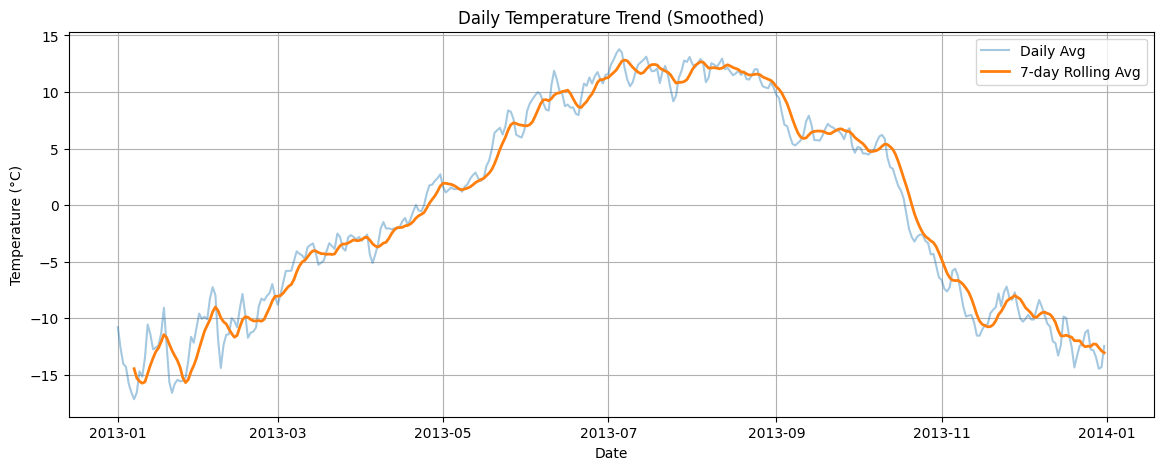

<Figure size 1200x500 with 0 Axes>

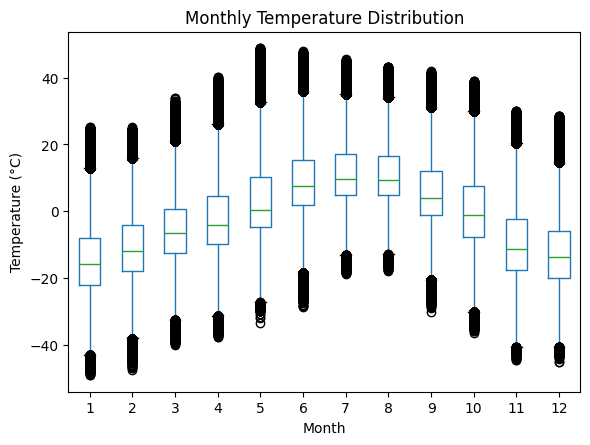

In [9]:
weather_part_1 = prepare_time_index(weather_part_1)

# Plot daily trend with rolling mean
plot_daily_trend_with_rolling(weather_part_1)

# Monthly boxplot
plot_monthly_boxplot(weather_part_1)

In [10]:
# Monthly outlier counts
monthly_outlier_count = get_monthly_outlier_counts(weather_part_1)
total_outliers = monthly_outlier_count['outlier_count'].sum()
print('Outlier percentage',total_outliers/len(weather_part_1))

Outlier percentage 0.030440385591070523


In [11]:
# get month, day columns
weather_part_1 = weather_part_1.reset_index()
weather_part_1["month"] = weather_part_1["time"].dt.month
weather_part_1["day"] = weather_part_1["time"].dt.day
weather_part_1.head()

,time,temperature,series_id,month,day
0,2013-01-01,-7.437500,"<37.0, 68.0>",1,1
1,2013-01-01,-11.156250,"<37.0, 68.25>",1,1
2,2013-01-01,-11.265625,"<37.0, 68.5>",1,1
3,2013-01-01,-11.023438,"<37.0, 68.75>",1,1
4,2013-01-01,-11.000000,"<37.0, 69.0>",1,1


In [12]:
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}
weather_part_1["month_name"] = weather_part_1["month"].map(month_map)
weather_part_1.head()

,time,temperature,series_id,month,day,month_name
0,2013-01-01,-7.437500,"<37.0, 68.0>",1,1,January
1,2013-01-01,-11.156250,"<37.0, 68.25>",1,1,January
2,2013-01-01,-11.265625,"<37.0, 68.5>",1,1,January
3,2013-01-01,-11.023438,"<37.0, 68.75>",1,1,January
4,2013-01-01,-11.000000,"<37.0, 69.0>",1,1,January


In [13]:
points_per_month = (
    weather_part_1
        .groupby(["series_id", "month"])
        .size()
        .reset_index(name="num_points")
)

points_per_month

,series_id,month,num_points
0,"<31.0, 68.0>",1,744
1,"<31.0, 68.0>",2,672
2,"<31.0, 68.0>",3,744
3,"<31.0, 68.0>",4,720
4,"<31.0, 68.0>",5,744
...,...,...,...
35095,"<37.0, 97.0>",8,744
35096,"<37.0, 97.0>",9,720
35097,"<37.0, 97.0>",10,744
35098,"<37.0, 97.0>",11,720


In [15]:
# take a particular series_id consider january month --> for each day --> consider hour resolution data
req_series_id = weather_part_1['series_id'].iloc[0]

df_plot = weather_part_1[
    (weather_part_1["series_id"] == req_series_id) &
    (weather_part_1["month"] == 1)
].copy()

df_plot = df_plot.sort_values("time")
df_plot.head()

,time,temperature,series_id,month,day,month_name
0,2013-01-01 00:00:00,-7.437500,"<37.0, 68.0>",1,1,January
2925,2013-01-01 01:00:00,-6.992188,"<37.0, 68.0>",1,1,January
5850,2013-01-01 02:00:00,-4.226562,"<37.0, 68.0>",1,1,January
8775,2013-01-01 03:00:00,-2.390625,"<37.0, 68.0>",1,1,January
11700,2013-01-01 04:00:00,-0.602539,"<37.0, 68.0>",1,1,January


In [16]:
df_plot['temperature'].describe()

count    744.000000
mean       3.248332
std        6.095486
min      -10.609375
25%       -0.779053
50%        3.081055
75%        7.664062
max       17.718750
Name: temperature, dtype: float64

In [17]:
def plot_month_hourly(
    df,
    req_series_id,
    month_num,
    time_col="time",
    value_col="temperature"
):
    """
    Plot hourly temperature for the entire month for one series_id
    """

    df_plot = df[
        (df["series_id"] == req_series_id) &
        (df[time_col].dt.month == month_num)
    ].copy()

    if df_plot.empty:
        print("No data found for given series_id and month.")
        return

    df_plot = df_plot.sort_values(time_col)

    plt.figure(figsize=(14, 5))
    plt.plot(df_plot[time_col], df_plot[value_col], linewidth=1)

    plt.title(f"Hourly Temperature – {month_map[month_num]} | Series ID: {req_series_id}")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

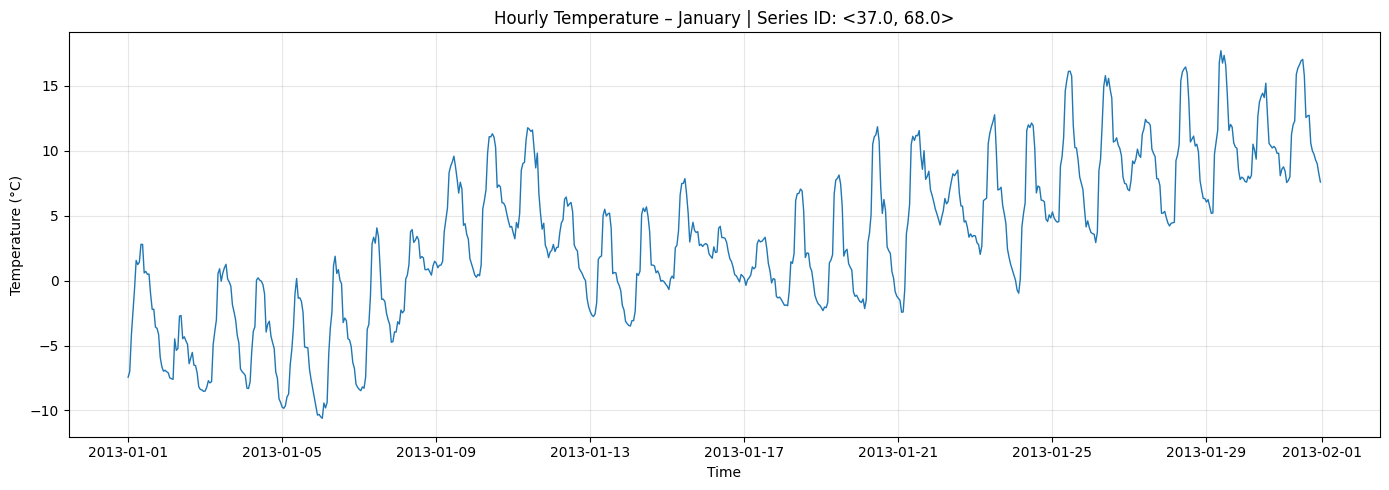

In [18]:
req_series_id = weather_part_1['series_id'].iloc[0]
plot_month_hourly(
    df=weather_part_1,
    req_series_id=req_series_id,
    month_num=1
)

In [19]:
def plot_with_iqr_spikes(
    df,
    req_series_id,
    month_num,
    value_col="temperature"
):

    # Filter data
    df_plot = df[
        (df["series_id"] == req_series_id) &
        (df['month'] == month_num)
    ].copy()

    if df_plot.empty:
        print("No data found.")
        return

    df_plot = df_plot.sort_index()

    # ---- IQR computation ----
    q1 = df_plot[value_col].quantile(0.25)
    q3 = df_plot[value_col].quantile(0.75)
    iqr = q3 - q1

    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr

    # Detect spikes
    spikes = df_plot[
        (df_plot[value_col] > upper) |
        (df_plot[value_col] < lower)
    ]

    # ---- Plot ----
    plt.figure(figsize=(15, 5))

    # Main series
    plt.plot(
        df_plot.index,
        df_plot[value_col],
        linewidth=1,
        label="Temperature"
    )

    # IQR threshold lines
    plt.axhline(upper, linestyle="--", linewidth=1, label="+1.5 × IQR")
    plt.axhline(lower, linestyle="--", linewidth=1, label="-1.5 × IQR")

    # Red shaded spike regions
    plt.fill_between(
        df_plot.index,
        upper,
        df_plot[value_col].max(),
        alpha=0.15
    )
    plt.fill_between(
        df_plot.index,
        df_plot[value_col].min(),
        lower,
        alpha=0.15
    )

    # Spike points
    plt.scatter(
        spikes.index,
        spikes[value_col],
        s=20,
        label="Spikes (IQR rule)"
    )

    plt.title(
        f"Hourly Temperature with IQR-based Spike Detection\n"
        f"Series ID: {req_series_id} | Month: {month_map[month_num]}"
    )
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

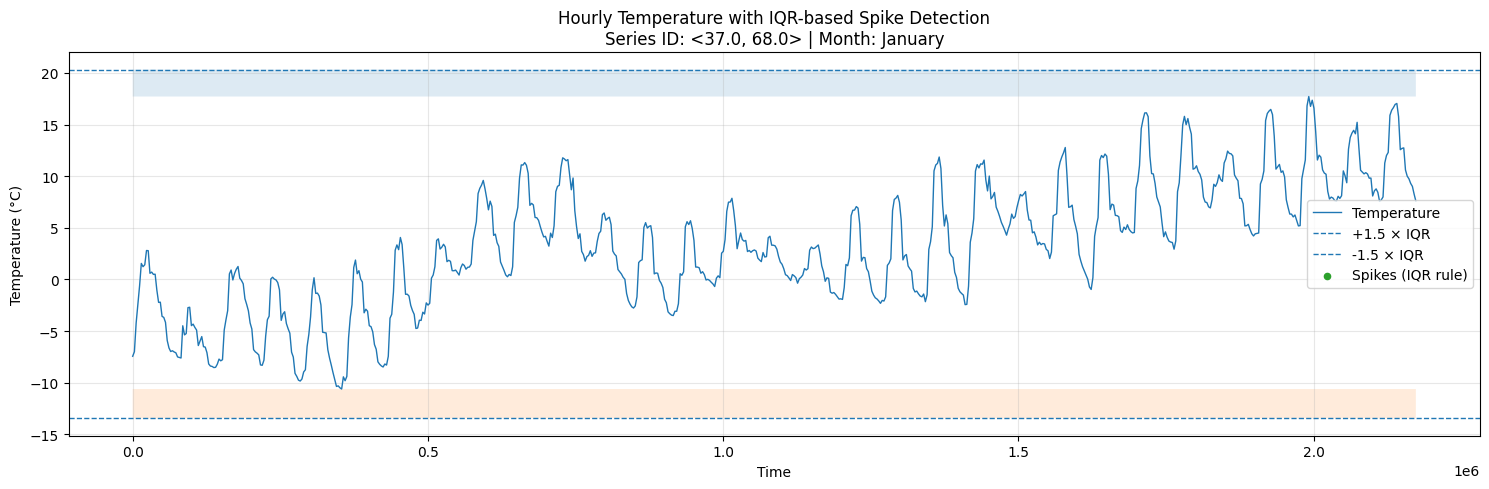

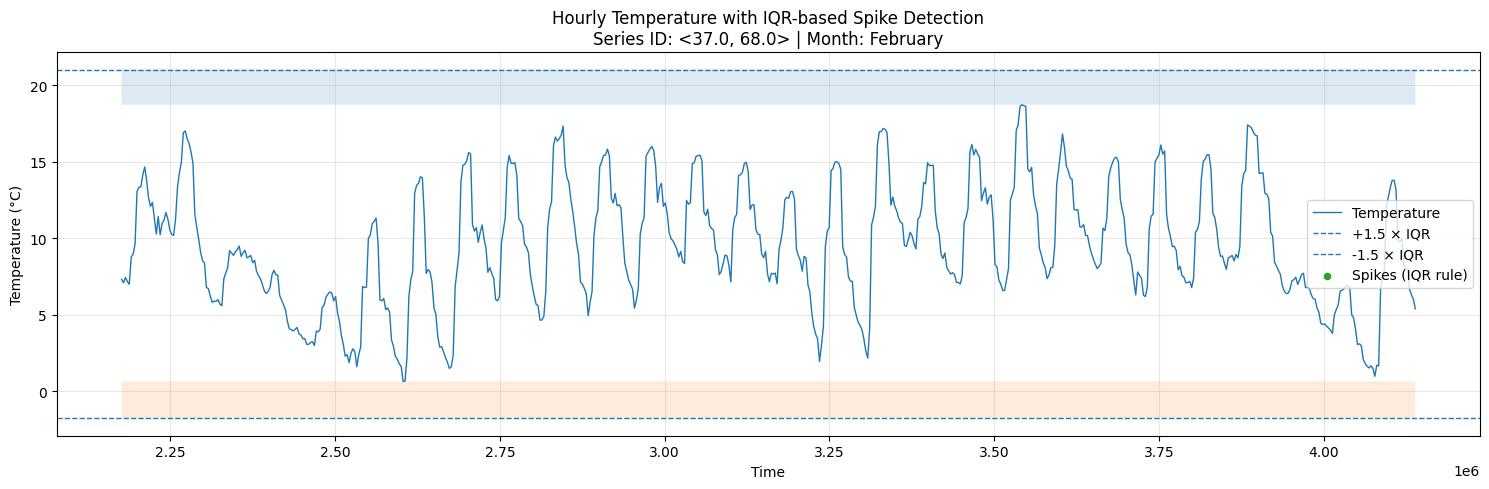

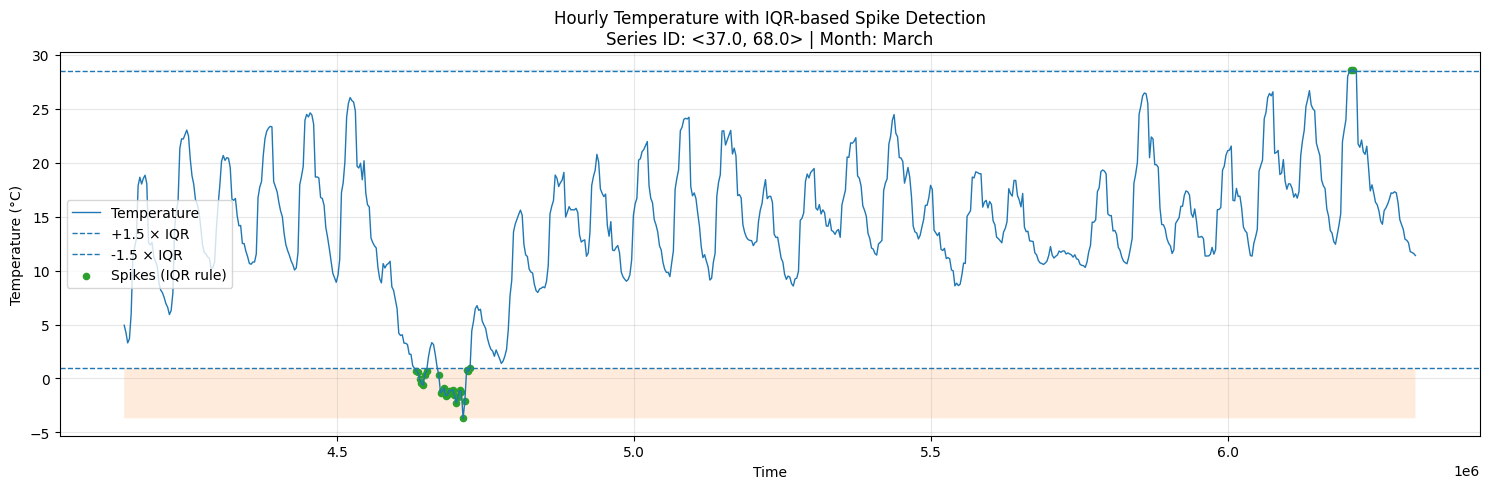

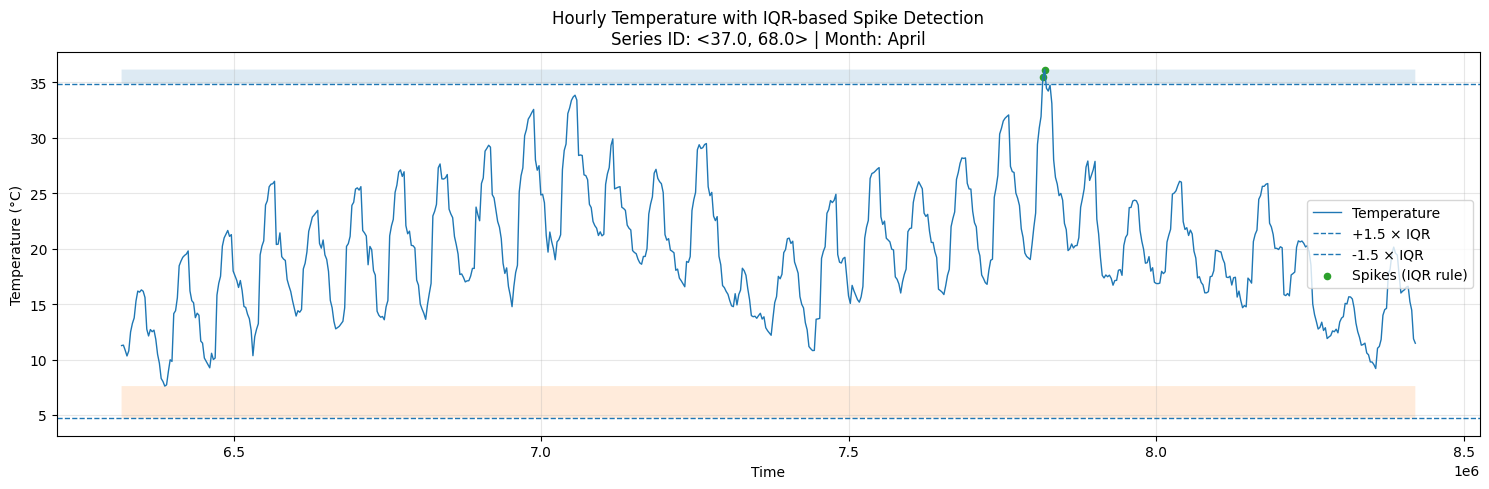

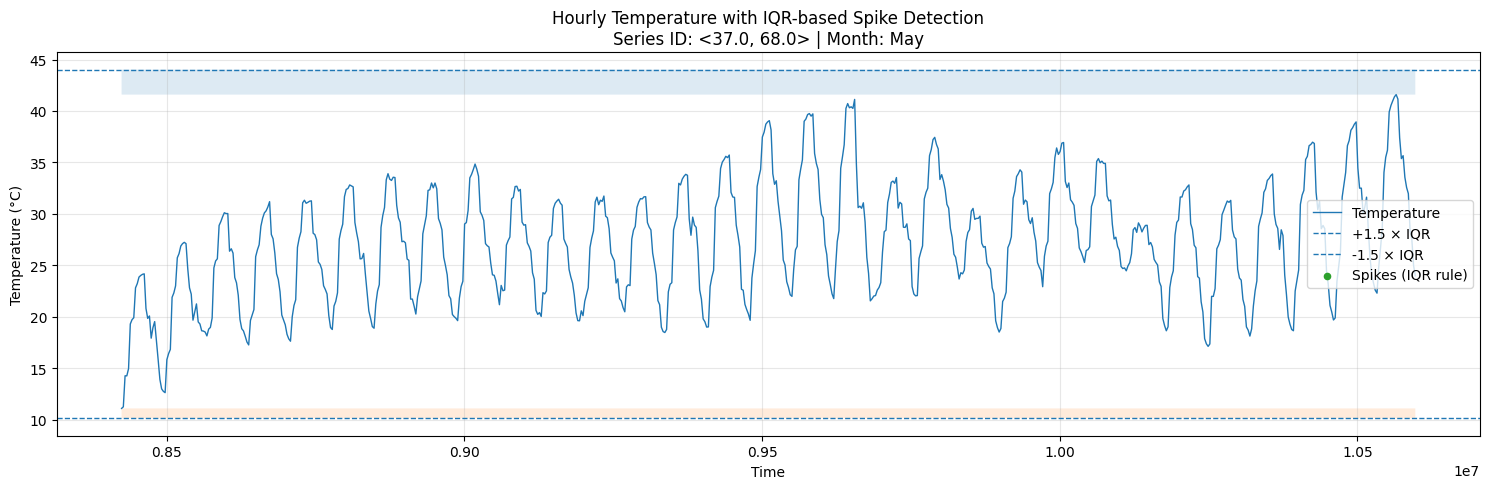

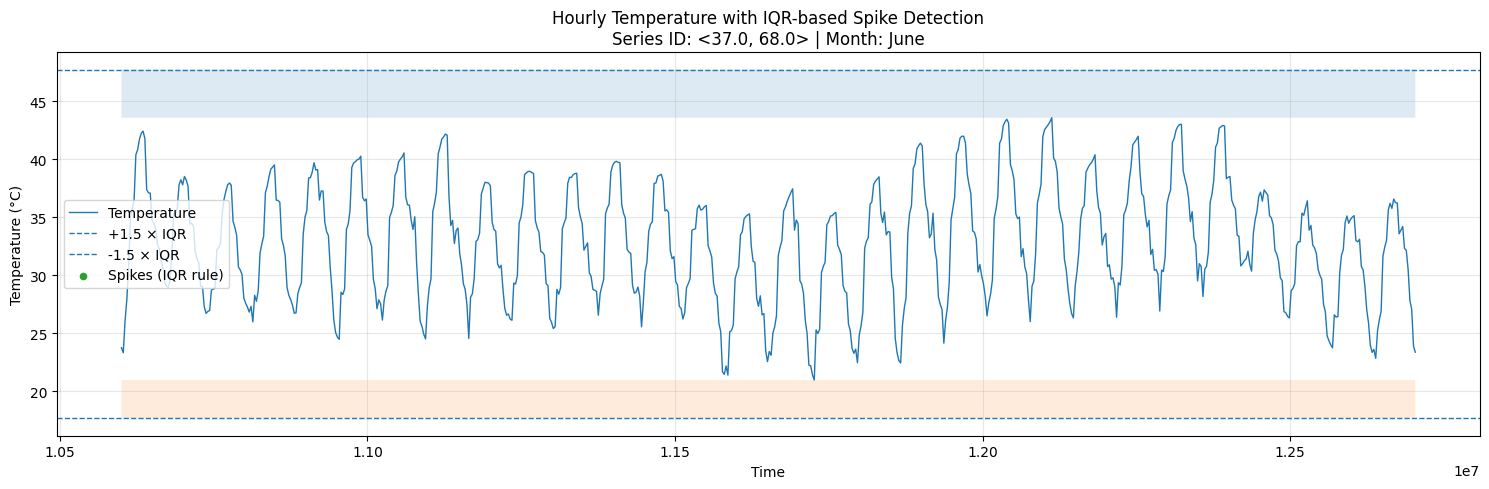

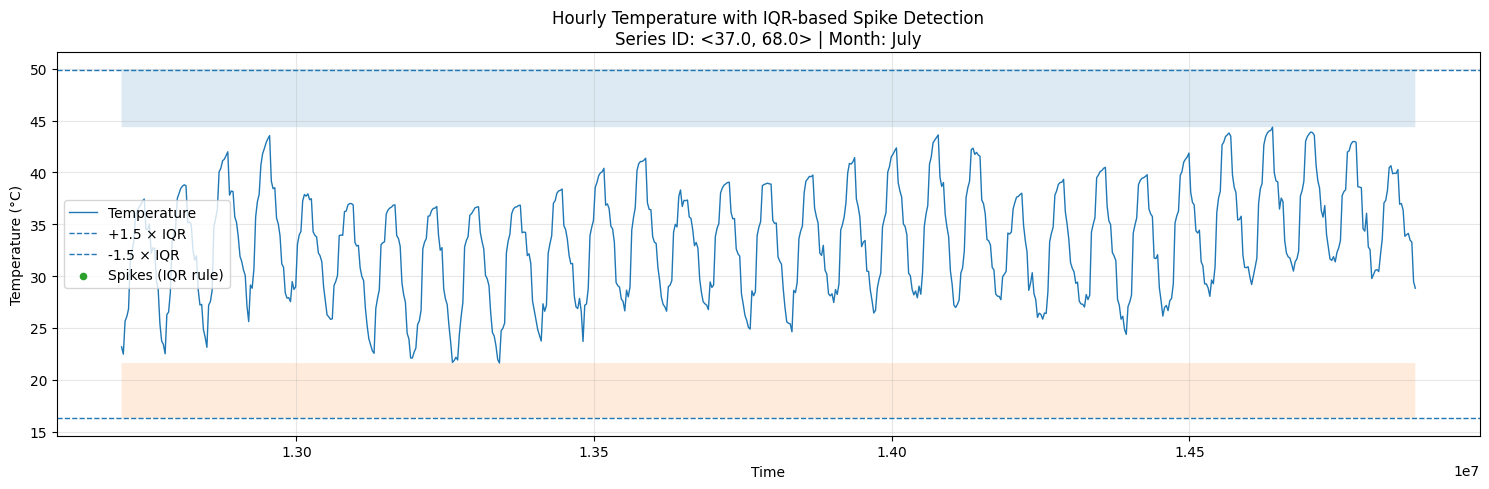

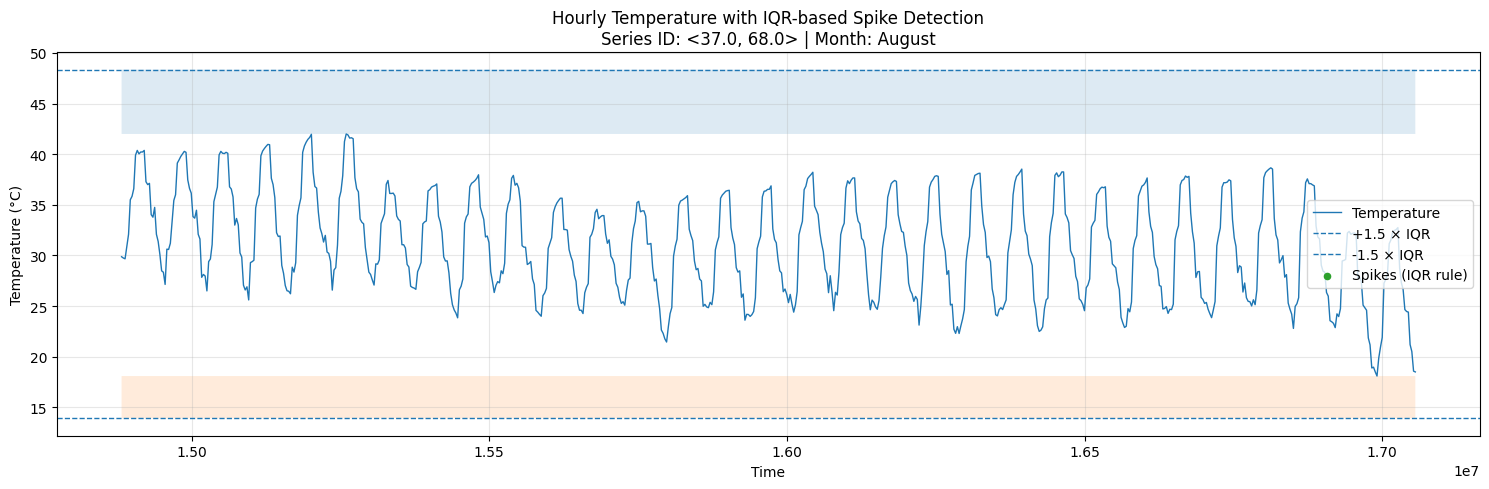

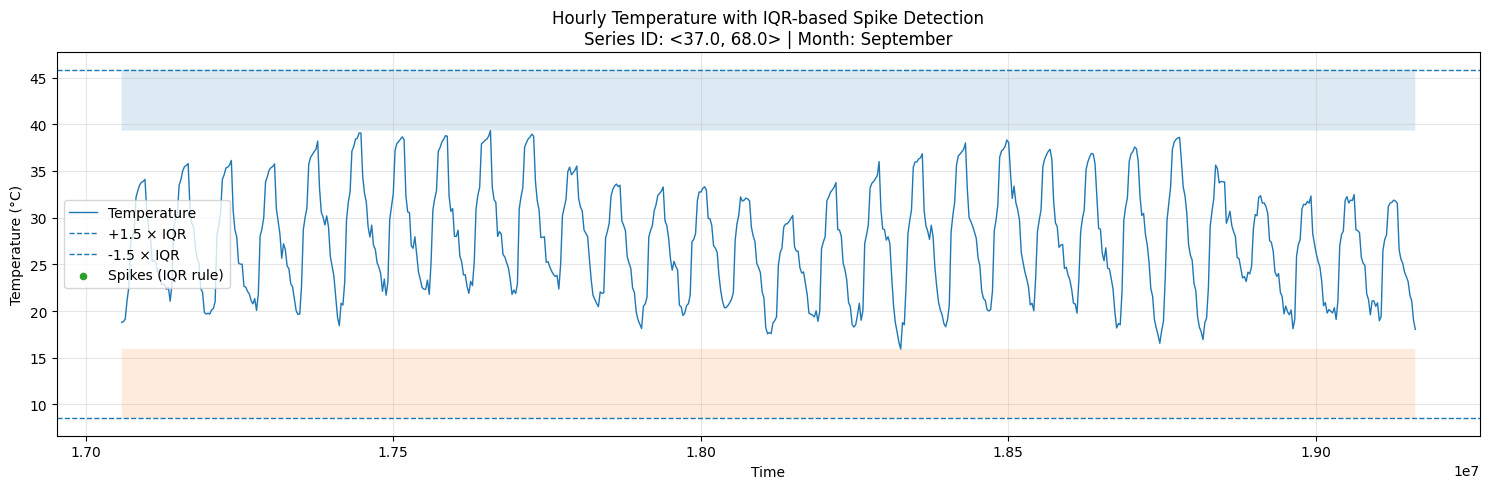

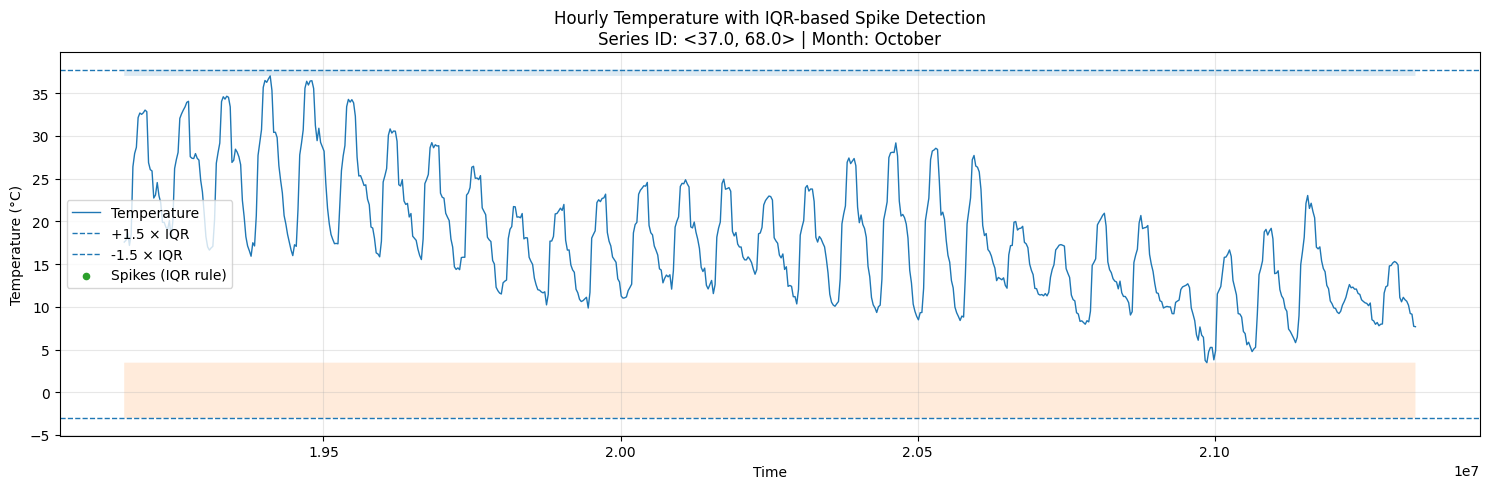

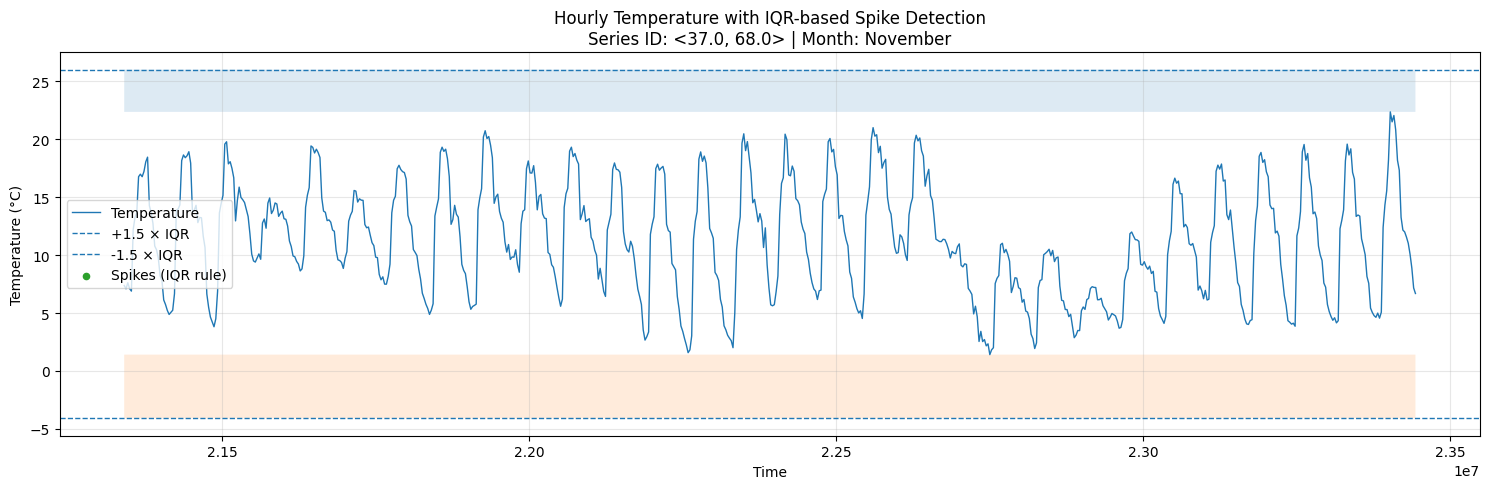

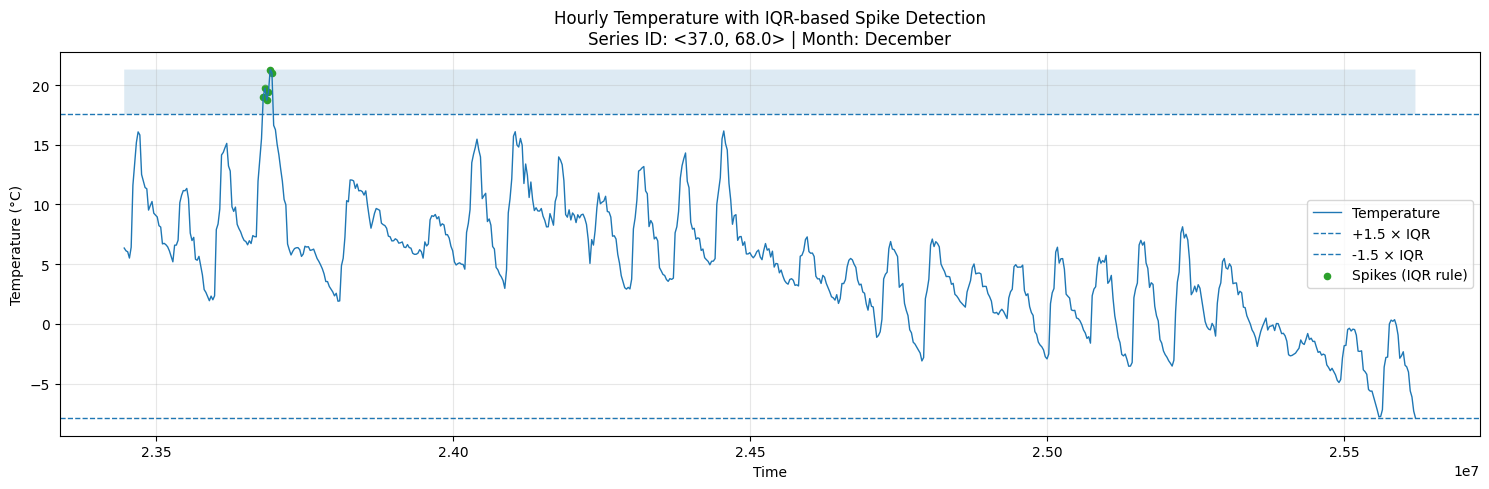

In [20]:
req_series_id = weather_part_1['series_id'].iloc[0]

for m in range(1,13):
    plot_with_iqr_spikes(
        df=weather_part_1,
        req_series_id=req_series_id,
        month_num=m
    )
    print()

In [51]:
def plot_5_days_hourly(
    df,
    req_series_id,
    month_num,
    time_col="time",
    value_col="temperature",
    num_days=5
):
    """
    Plot hourly temperature for first `num_days` days of a month
    for one series_id
    """

    df_plot = df[
        (df["series_id"] == req_series_id) &
        (df[time_col].dt.month == month_num)
    ].copy()

    if df_plot.empty:
        print("No data found for given series_id and month.")
        return

    # Extract day and hour
    df_plot["day"] = df_plot[time_col].dt.day
    df_plot["hour"] = df_plot[time_col].dt.hour

    # Take first `num_days` available days
    selected_days = sorted(df_plot["day"].unique())[:num_days]
    df_plot = df_plot[df_plot["day"].isin(selected_days)]

    df_plot = df_plot.sort_values([ "day", "hour" ])

    plt.figure(figsize=(14, 5))

    for day, g in df_plot.groupby("day"):
        plt.plot(
            g["hour"],
            g[value_col],
            linewidth=1,
            label=f"Day {day}"
        )

    plt.xticks(range(0, 24))
    plt.title(
        f"Hourly Temperature – First {num_days} Days of {month_map[month_num]}\n"
        f"Series ID: {req_series_id}"
    )
    plt.xlabel("Hour of Day")
    plt.ylabel("Temperature (°C)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

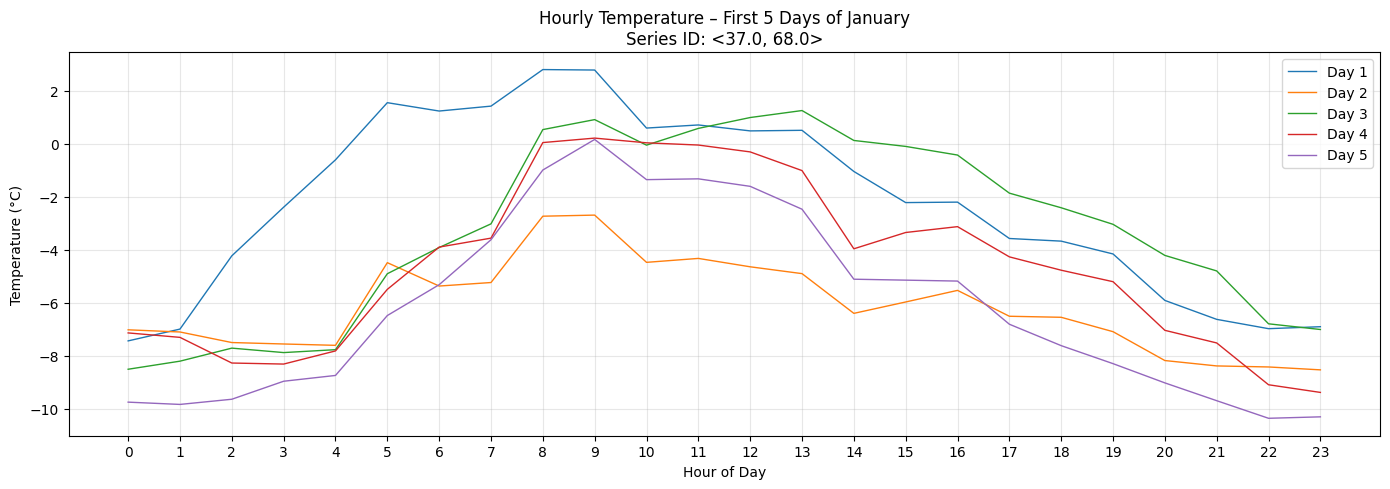

In [52]:
plot_5_days_hourly(
    df=weather_part_1,
    req_series_id=req_series_id,
    month_num=1
)